# Analyze healthcare workers

We will analyze demographics, as well as correlation between psychometric scores to predict if their work experience affects their mental health

In [1]:
# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import quandl
import pandas as pd
df = quandl.get('WIKI/GOOGL')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')


# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
plt.rcParams.update({'font.size': 15})
style.use('seaborn-paper') #sets the size of the charts
style.use('ggplot')

bg_color = (0.96862745, 0.96862745, 0.96862745)
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

In [2]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)
    
print('%d participants'%len(db))
print('%s responses'%len(utils.cat_arrays(db, 'timestamps')))

1187 participants
16011 responses


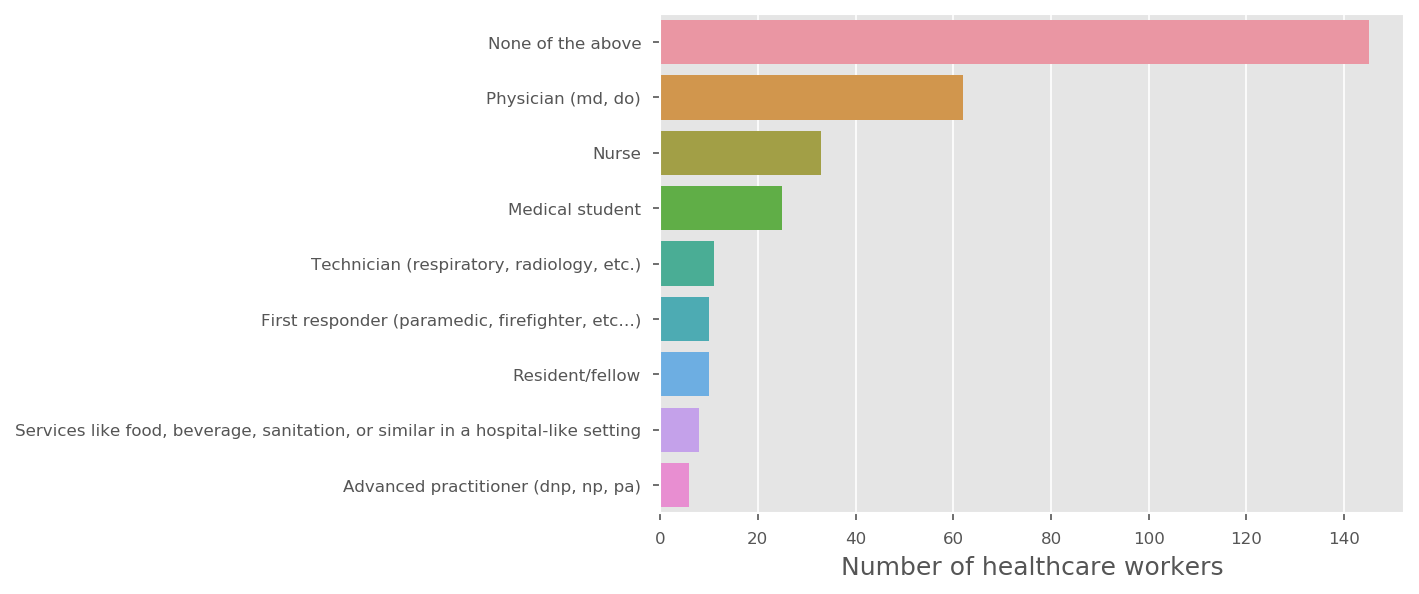

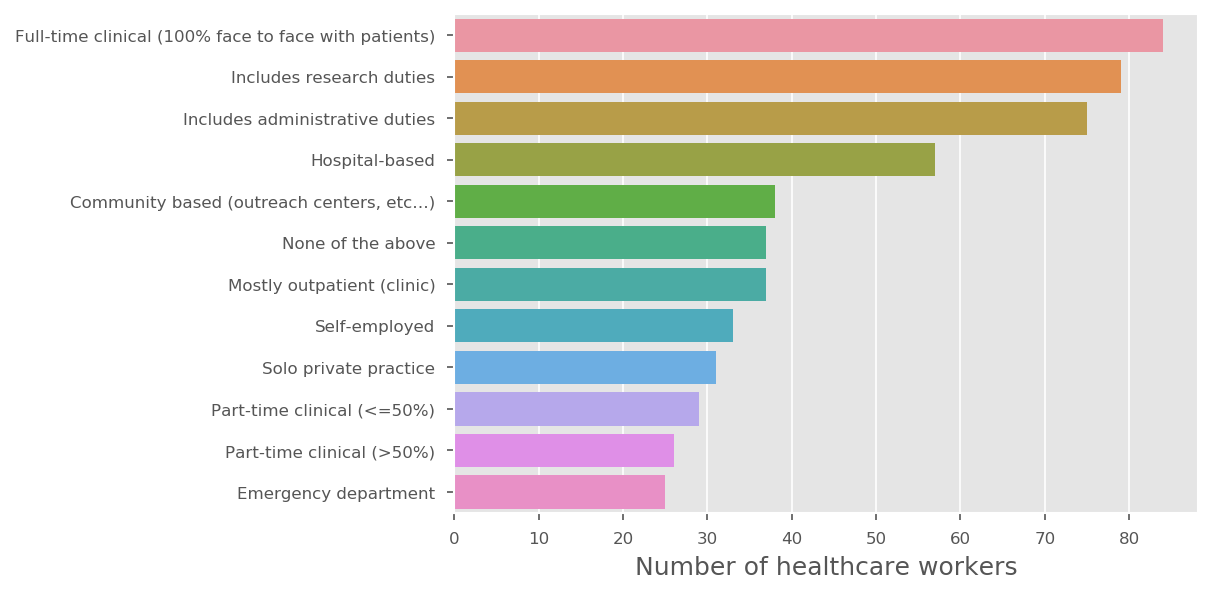

In [3]:
# Plot some demographics
health_db = {key:db[key] for key in db if db[key]['healthcare_worker'] and 'healthcare_speciality' in db[key]}
hdb2 = {key:db[key] for key in db if db[key]['healthcare_worker']}

specialities = []

for key in health_db:
    speciality = health_db[key]['healthcare_speciality']
    
    if type(speciality) == str:
        specialities.append(json.loads(speciality)['Speciality'])
    else:
        specialities += speciality

healthcare_jobs = Counter(utils.getall(hdb2, 'healthcare_job'))
jobs = np.array([name.replace('I am a ', '').replace('I work in ', '').capitalize() for name in list(healthcare_jobs.keys())])
values = np.array(list(healthcare_jobs.values()))

indices = np.argsort(values)[::-1]

fig = plt.figure(dpi=150)
sns.barplot(values[indices], jobs[indices])
plt.xlabel('Number of healthcare workers')
plt.show()

healthcare_work = Counter(utils.cat_arrays(hdb2, 'healthcare_work'))

del healthcare_work['(empty)']

works = np.array([name.capitalize() for name in list(healthcare_work.keys())])
values = np.array(list(healthcare_work.values()))

indices = np.argsort(values)[::-1]

fig = plt.figure(dpi=150)
sns.barplot(values[indices], works[indices])
plt.xlabel('Number of healthcare workers')
plt.show()
            

In [5]:
# Now we are ready to regress. Start by popping out only the last responded QIDS, and mood

week_freq =  4
epoch1 = 24*3600*(datetime.datetime(2020, 4, 1, 0, 0).timestamp()//(24*3600))*1000
epoch2 = 24*3600*(datetime.datetime(2020, 9, 14, 0, 0).timestamp()//(24*3600))*1000

const = 24*3600*1000*7*week_freq
week_bins = np.arange(epoch1, epoch2 + const, const)
nweeks = len(week_bins)

valid_ids = [key for key in db if   len(db[key]['A']) > 0 and\
             'camsr' in db[key]  and len(db[key]['K']) > 0]

rdb = {key:db[key] for key in valid_ids}

rdict = dict()

for idx in range(nweeks):
    rdict['qids%d'%(idx+1)] = []
    rdict['mood%d'%(idx+1)] = []
    
rdict['qids'] = []
rdict['mood'] = []
rdict['camsr'] = []
rdict['neuroticism'] = []
rdict['pre_physical'] = []
rdict['pre_mental'] = []
rdict['substance'] = []

#All the participants 

for key in valid_ids:
    qids_arr = rdb[key]['QIDS']
    K_panel = rdb[key]['K'][-1]
    
    for idx in range(nweeks):
        rdict['qids%d'%(idx+1)].append(float('Nan'))
        rdict['mood%d'%(idx+1)].append(float('Nan'))
        
    for ts, qids_val in qids_arr.items():
        timeval = (float(ts)*1000 - epoch1)//const + 1
        rdict['qids%d'%timeval][-1] = qids_val
        
    for A_panel in rdb[key]['A']:
        timeval = (A_panel['timestamp']*1000 - epoch1)//const + 1
        rdict['mood%d'%timeval][-1] = A_panel['mood']
        
    rdict['qids'].append(list(rdb[key]['QIDS'].values())[0])
    rdict['mood'].append(rdb[key]['A'][-1]['mood'])
    rdict['substance'].append(rdb[key]['A'][-1]['substance'])
    rdict['camsr'].append(rdb[key]['camsr'])
    rdict['neuroticism'].append(rdb[key]['ipip'][4])
    rdict['pre_physical'].append(len(rdb[key]['pre_physical']))
    rdict['pre_mental'].append(len(rdb[key]['pre_mental']))
    
    
    for key2 in K_panel:
        if 'away_from_work' in key2 or 'timestamp' in key2 or 'note' in key2 or 'ID' in key2:
            pass
        else:
            try:
                rdict[key2].append(K_panel[key2])
            except KeyError:
                rdict[key2] = []
                rdict[key2].append(K_panel[key2])
    
rpd = pd.DataFrame.from_dict(rdict)

rpd

,qids1,mood1,qids2,mood2,qids3,mood3,qids4,mood4,qids5,mood5,qids6,mood6,qids7,mood7,qids,mood,camsr,neuroticism,pre_physical,pre_mental,substance,burnout_risk,burnout_protective,burnout
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,2.0,17.0,2.0,NaN,NaN,19,2,20,3.25,1,3,1,9,14,5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,0.0,NaN,NaN,NaN,NaN,17,0,20,1.25,1,1,-2,8,18,10
2,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2.0,7.0,3.0,NaN,NaN,NaN,NaN,10,2,23,1.75,2,1,-2,4,22,18
3,NaN,NaN,NaN,NaN,NaN,NaN,10.0,3.0,7.0,3.0,7.0,3.0,2.0,3.0,16,3,21,1.50,1,1,0,15,13,-2
4,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,18.0,1.0,24.0,1.0,NaN,NaN,19,1,22,1.75,1,1,0,11,12,1
5,NaN,NaN,NaN,NaN,5.0,5.0,2.0,4.0,0.0,5.0,2.0,5.0,NaN,NaN,2,5,37,2.00,1,1,0,2,24,22
6,NaN,NaN,NaN,NaN,4.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,6,2,29,1.50,1,1,0,2,22,20
7,NaN,NaN,NaN,NaN,NaN,NaN,9.0,4.0,4.0,3.0,4.0,2.0,NaN,NaN,9,2,16,1.50,1,1,0,10,16,6
8,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2.0,11.0,1.0,NaN,NaN,NaN,NaN,14,1,26,1.50,2,2,-2,5,19,14
9,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN,8,2,20,2.25,1,1,0,7,20,13


In [7]:
rdict['qids1']

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [8]:
print(rpd.shape)

# July 1 till July 15  >> qids6
print(np.count_nonzero(~np.isnan(rpd['qids6'])))
print(np.count_nonzero(~np.isnan(rpd['mood6'])))

# July 15 till July 29  >> qids7
print(np.count_nonzero(~np.isnan(rpd['qids7'])))
print(np.count_nonzero(~np.isnan(rpd['mood7'])))

rpd['neuroticism'] = rpd['neuroticism'] / (1.0*max(rpd['neuroticism'])) 
rpd['qids'] = rpd['qids'] / (1.0*max(rpd['qids'])) 
rpd['camsr'] = rpd['camsr'] / (1.0*max(rpd['camsr']))
rpd['pre_physical'] = rpd['pre_physical'] / (1.0*max(rpd['pre_physical']))
rpd['pre_mental'] = rpd['pre_mental'] / (1.0*max(rpd['pre_mental']))


(65, 24)
31
31
24
24


In [9]:

varnames = ['mood', 'camsr','burnout','neuroticism','pre_physical','pre_mental']
dep_varname = 'qids'

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
Y = rpd[dep_varname]
X = rpd[varnames]
k = 8
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []
coeff_list = []
#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
    #coeff_list.append([])
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        est = sm.GLS(endog=Y, exog=X[list(combo)], missing='drop')
        est2 = est.fit()
        #print(est2.mse_total)
        RSS_list.append(est2.ssr)                  #Append lists
        R_squared_list.append(est2.rsquared_adj)
        feature_list.append(combo)
        coeff_list.append((est2.params))
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'coefficients':coeff_list})
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
#display(df_min)
display(df_max)

#df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(lambda x: x.nsmallest(2).min())
#df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(lambda x: x.nlargest(2).max())
df.head(30)

/home/vishwanath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


,numb_features,RSS,R_squared,coefficients
4,1,5.102699,0.711607,pre_physical 1.147159 dtype: float64
20,2,3.884911,0.776948,pre_physical 0.632166 pre_mental 0.604259 dtype: float64
39,3,3.552803,0.792726,burnout -0.009318 pre_physical 0.874887 pre_mental 0.625848 dtype: float64
55,4,3.442034,0.795896,burnout -0.011159 neuroticism 0.190045 pre_physical 0.702939 pre_mental 0.571788 dtype: float64
61,5,3.334915,0.798952,camsr -0.215774 burnout -0.008644 neuroticism 0.290942 pre_physical 0.841986 pre_mental 0.611452 dtype: float64
62,6,3.330099,0.795840,mood -0.009664 camsr -0.191368 burnout -0.008402 neuroticism 0.304663 pre_physical 0.834658 pre_mental 0.604849 dtype: float64


,numb_features,RSS,R_squared,coefficients
0,1,8.786225,0.503422,mood 0.142384 dtype: float64
1,1,6.780368,0.616788,camsr 0.559368 dtype: float64
2,1,11.001228,0.378235,burnout 0.024594 dtype: float64
3,1,5.962926,0.662989,neuroticism 0.716018 dtype: float64
4,1,5.102699,0.711607,pre_physical 1.147159 dtype: float64
5,1,5.133533,0.709864,pre_mental 1.108982 dtype: float64
6,2,6.723790,0.613954,mood -0.030781 camsr 0.661446 dtype: float64
7,2,8.761275,0.496972,mood 0.130750 burnout 0.002736 dtype: float64
8,2,5.889736,0.661841,mood -0.030242 neuroticism 0.836702 dtype: float64
9,2,5.078501,0.708418,mood -0.014640 pre_physical 1.233503 dtype: float64


In [10]:
# Now we are ready to regress

# We have to assemble our data first
dep_varname = 'qids'
#varnames = [column for column in rpd if ((column is not dep_varname) and (column != 'friends_medication') and (column != 'self_medicated') and\
#                                        column != 'patients_died')]

varnames = ['neuroticism']

varlabels = ['Neuroticism']

est = sm.GLS(endog=rpd[dep_varname], exog=rpd[varnames], missing='drop')
est2 = est.fit()

summary = est2.summary(xname=varlabels, yname=dep_varname.upper())
print(summary)

summary_csv = summary.as_csv()
with open('healthcare_ols_regression.csv', 'w') as f:
    f.write(summary_csv)

                                 GLS Regression Results                                
Dep. Variable:                   QIDS   R-squared (uncentered):                   0.668
Model:                            GLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              128.9
Date:                Tue, 29 Sep 2020   Prob (F-statistic):                    5.63e-17
Time:                        13:41:25   Log-Likelihood:                         -14.594
No. Observations:                  65   AIC:                                      31.19
Df Residuals:                      64   BIC:                                      33.36
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [12]:
# We are going to do a time-based regression! All hail King Julien!

week_freq =  4
epoch1 = 24*3600*(datetime.datetime(2020, 4, 1, 0, 0).timestamp()//(24*3600))*1000
epoch2 = 24*3600*(datetime.datetime(2020, 9, 14, 0, 0).timestamp()//(24*3600))*1000

const = 24*3600*1000*7*week_freq
week_bins = np.arange(epoch1, epoch2 + const, const)
nweeks = len(week_bins)

valid_ids = [key for key in db if   len(db[key]['QIDS']) > 1 and\
             'camsr' in db[key]  and len(db[key]['A']) > 1 and
             db[key]['state'] is not None and\
             'Texas' in db[key]['state']]
print(len(valid_ids))

rdb = {key:db[key] for key in valid_ids}

rdict = dict()

for idx in range(nweeks):
    rdict['qids%d'%(idx+1)] = []
    rdict['mood%d'%(idx+1)] = []
    rdict['substance%d'%(idx+1)] = []
    
rdict['qids'] = []
rdict['mood'] = []
rdict['camsr'] = []
rdict['neuroticism'] = []
rdict['pre_physical'] = []
rdict['pre_mental'] = []
#rdict['substance'] = []
rdict['age'] = []
rdict['gender'] = []

gender_dict = {'male': 0, 'female': 1}

# All the participants 

for key in valid_ids:
    qids_arr = rdb[key]['QIDS']
    
    for idx in range(nweeks):
        rdict['qids%d'%(idx+1)].append(float('Nan'))
        rdict['mood%d'%(idx+1)].append(float('Nan'))
        rdict['substance%d'%(idx+1)].append(float('Nan'))
        
    for ts, qids_val in qids_arr.items():
        timeval = (float(ts)*1000 - epoch1)//const + 1
        rdict['qids%d'%timeval][-1] = qids_val
        
    for A_panel in rdb[key]['A']:
        timeval = (A_panel['timestamp']*1000 - epoch1)//const + 1
        rdict['mood%d'%timeval][-1] = A_panel['mood']
        rdict['substance%d'%timeval][-1] = A_panel['substance']
        
    
    rdict['age'].append(rdb[key]['age'])
    rdict['gender'].append(gender_dict[rdb[key]['gender']])
    rdict['qids'].append(list(rdb[key]['QIDS'].values())[0])
    rdict['mood'].append(rdb[key]['A'][-1]['mood'])
    #rdict['substance'].append(rdb[key]['A'][-1]['substance'])
    rdict['camsr'].append(rdb[key]['camsr'])
    rdict['neuroticism'].append(rdb[key]['ipip'][4])
    rdict['pre_physical'].append(len(rdb[key]['pre_physical']))
    rdict['pre_mental'].append(len(rdb[key]['pre_mental']))
    
rpd = pd.DataFrame.from_dict(rdict)

rpd['delta_qids'] = rpd['qids6'] - rpd['qids5']
rpd['delta_mood'] = rpd['mood6'] - rpd['mood5']

rpd

34


,qids1,mood1,substance1,qids2,mood2,substance2,qids3,mood3,substance3,qids4,mood4,substance4,qids5,mood5,substance5,qids6,mood6,substance6,qids7,mood7,substance7,qids,mood,camsr,neuroticism,pre_physical,pre_mental,age,gender,delta_qids,delta_mood
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,9.0,1.0,0.0,9.0,1.0,0.0,NaN,NaN,NaN,7,1,33,2.00,1,1,41,1,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1.0,1.0,13.0,3.0,1.0,14.0,2.0,2.0,13.0,3.0,1.0,14,3,23,1.50,1,1,42,1,1.0,-1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,0.0,2.0,3.0,0.0,4.0,2.0,0.0,4.0,3.0,0.0,10.0,1.0,0.0,6,3,32,2.00,1,1,70,1,0.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.0,0.0,9.0,3.0,0.0,6.0,2.0,1.0,NaN,NaN,NaN,15,3,15,2.00,2,1,62,1,-3.0,-1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,9.0,2.0,0.0,9.0,2.0,0.0,NaN,NaN,NaN,9,2,21,1.50,1,1,21,0,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2.0,0.0,14.0,2.0,0.0,17.0,1.0,1.0,17.0,2.0,0.0,12,2,24,2.00,1,1,49,1,3.0,-1.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,0.0,3.0,4.0,0.0,3.0,2.0,0.0,6.0,3.0,0.0,4,3,30,2.00,1,2,43,1,0.0,-2.0
7,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,29,1.50,1,1,38,0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,4.0,0.0,4.0,3.0,0.0,4.0,2.0,0.0,NaN,NaN,NaN,9,2,16,1.50,1,1,38,1,0.0,-1.0
9,NaN,NaN,NaN,4.0,3.0,0.0,3.0,3.0,0.0,3.0,2.0,0.0,4.0,3.0,0.0,4.0,3.0,0.0,5.0,3.0,0.0,4,2,28,1.50,1,1,43,0,0.0,0.0


In [13]:
# Normalize the variables
rpd['neuroticism'] = rpd['neuroticism'] / (1.0*max(rpd['neuroticism'])) 
rpd['camsr'] = rpd['camsr'] / (1.0*max(rpd['camsr']))
rpd['pre_physical'] = rpd['pre_physical'] / (1.0*max(rpd['pre_physical']))
rpd['pre_mental'] = rpd['pre_mental'] / (1.0*max(rpd['pre_mental']))

# Now regress
varnames = ['camsr', 'neuroticism', 'pre_physical', 'pre_mental', 'delta_mood', 'gender', 'substance5', 'substance6']
#varlabels = ['Mindfulness', 'Neuroticism', 'Pre-existing physical', 'Pre existing mental', 'Mood in first week',
#            'Mood in second week', 'Gender (Female = 1)']
dep_varname = 'delta_qids'

X = rpd[varnames]
Y = rpd[dep_varname]

#est = sm.GLS(endog=rpd[dep_varname], exog=rpd[varnames], missing='drop')
#est2 = est.fit()

#summary = est2.summary(xname=varlabels, yname=dep_varname.upper())
#print(summary)

#summary_csv = summary.as_csv()
#with open('delta_qids_regression.csv', 'w') as f:
#    f.write(summary_csv)

k = len(varnames)
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []
coeff_list = []

# Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
    # Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        est = sm.GLS(endog=Y, exog=X[list(combo)], missing='drop')
        est2 = est.fit()
        
        RSS_list.append(est2.ssr)                  #Append lists
        R_squared_list.append(est2.rsquared_adj)
        feature_list.append(combo)
        coeff_list.append((est2.params))
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'coefficients':coeff_list})
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]

display(df_max)

#df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(lambda x: x.nsmallest(2).min())
#df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(lambda x: x.nlargest(2).max())
df


/home/vishwanath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


,numb_features,RSS,R_squared,coefficients
4,1,182.750000,0.106270,delta_mood -0.916667 dtype: float64
10,2,173.279972,0.115738,camsr 4.959370 pre_mental -13.799175 dtype: float64
47,3,126.869477,0.323146,camsr 5.920485 pre_mental -16.642973 delta_mood -1.156675 dtype: float64
107,4,108.331186,0.394527,camsr 9.271540 pre_physical -5.067135 pre_mental -15.810564 delta_mood -1.275820 dtype: float64
162,5,91.190310,0.464846,camsr 7.154050 neuroticism 5.117584 pre_physical -9.178710 pre_mental -14.455608 delta_mood -1.487154 dtype: float64
218,6,90.252648,0.442472,camsr 7.216730 neuroticism 5.743496 pre_physical -8.845819 pre_mental -15.281277 delta_mood -1.508298 gender -0.545151 dtype: float64
246,7,89.573858,0.415924,camsr 7.020632 neuroticism 5.949975 pre_physical -8.976905 pre_mental -14.991192 delta_mood -1.511067 gender -0.491028 substance5 0.229159 dtype: float64
254,8,89.431618,0.382549,camsr 7.035582 neuroticism 6.119889 pre_physical -9.157396 pre_mental -15.012867 delta_mood -1.502738 gender -0.538239 substance5 0.182609 substance6 0.108608 dtype: float64


,numb_features,RSS,R_squared,coefficients
0,1,212.933063,-0.041339,camsr -0.074812 dtype: float64
1,1,212.947573,-0.041410,neuroticism -0.069903 dtype: float64
2,1,210.714286,-0.030488,pre_physical -0.571429 dtype: float64
3,1,207.311111,-0.013845,pre_mental -1.777778 dtype: float64
4,1,182.750000,0.106270,delta_mood -0.916667 dtype: float64
5,1,212.947368,-0.041409,gender 0.052632 dtype: float64
6,1,211.933333,-0.036450,substance5 0.266667 dtype: float64
7,1,213.000000,-0.041667,substance6 -5.551115e-17 dtype: float64
8,2,212.930797,-0.086603,camsr -0.114631 neuroticism 0.044482 dtype: float64
9,2,197.969660,-0.010255,camsr 3.150623 pre_physical -4.462330 dtype: float64


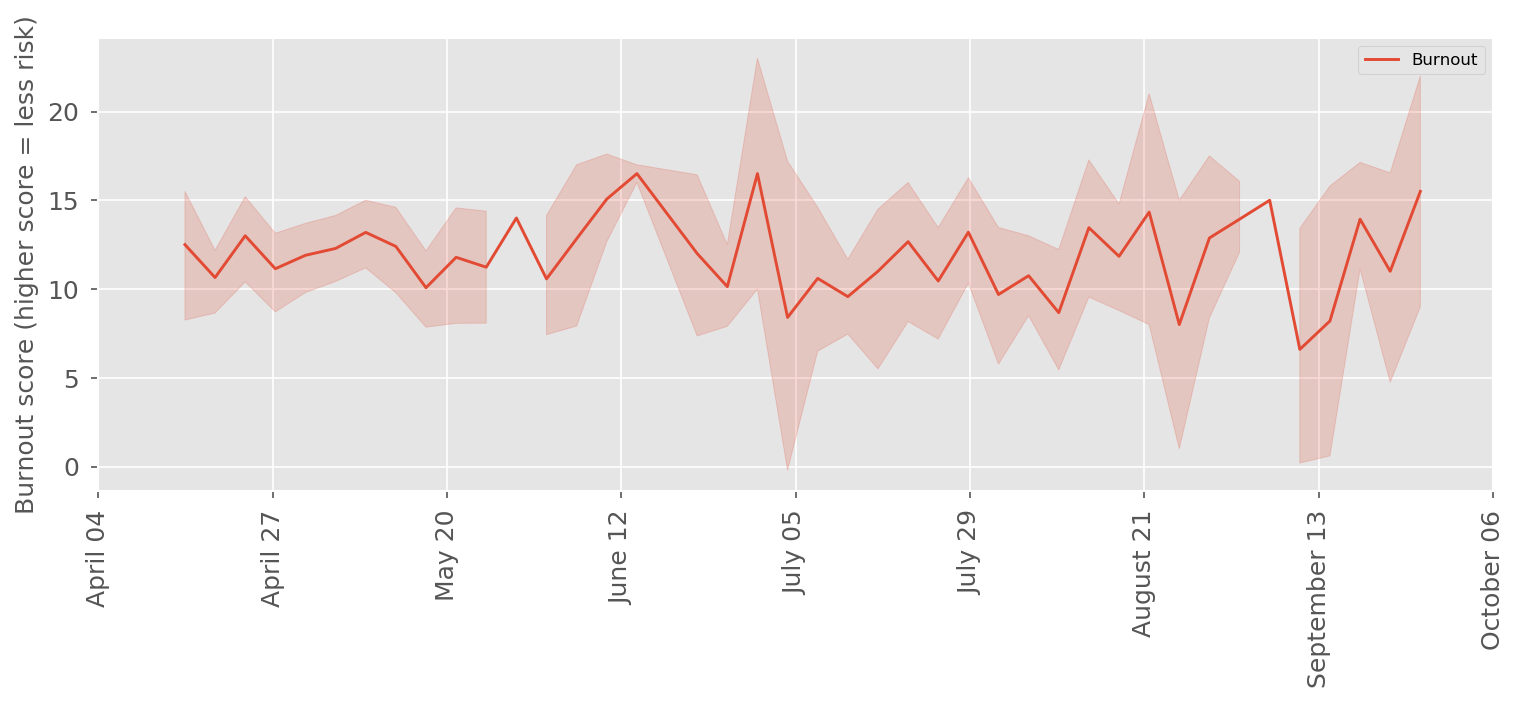

In [14]:
# Analyze burnout ids
burnout_ids = [key for key in db if len(db[key]['K']) > 0 and\
               db[key]['country'] is not None and db[key]['country'] == 'United States of America']

burnout_dict = {'risk':[], 'protective': [], 'timestamp': [], 'burnout': []}

const = 3600*24*4

for key in burnout_ids:
    K_panels = db[key]['K']
    
    for K_panel in K_panels:
        burnout_dict['risk'].append(K_panel['burnout_risk'])
        burnout_dict['protective'].append(K_panel['burnout_protective'])
        burnout_dict['burnout'].append(burnout_dict['protective'][-1] - burnout_dict['risk'][-1])
        burnout_dict['timestamp'].append(const*(K_panel['timestamp'] // const))
        
burnout_pd = pd.DataFrame.from_dict(burnout_dict)

fig = plt.figure(dpi=150, figsize=[12, 4])
sns.lineplot(x='timestamp', y='burnout', data=burnout_pd, label='Burnout')
#sns.lineplot(x='timestamp', y='protective', data=burnout_pd, label='Burnout protective')
plt.xlabel('')
plt.ylabel('Burnout score (higher score = less risk)')

timestamps, _ = plt.xticks()

plt.xticks(timestamps, labels=[d2s(timestamp*1000) for timestamp in timestamps], rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)

plt.show()